# XGBoost Analysis on Airline Customer Satisfaction

## Introduction

The XGBoost model is a very powerful extension of decision trees.

This project is a continuation of the airlines project in which I built decision tree and random forest models. I will use the same data, but this time I will train, tune, and evaluate an XGBoost model. I’ll then compare the performance of all three models and decide which model is best. Finally, I’ll explore the feature importances of the model and identify the features that most contribute to customer satisfaction.

## Step 1: Imports

### Import packages

Begin with the import statements. First, import `pandas`, `numpy`, and `matplotlib` for data preparation. Next, import scikit-learn (`sklearn`) for model preparation and evaluation. Then, import `xgboost`, which provides the classification algorithm I'll implement to formulate the predictive model.

In [1]:
# Import relevant libraries and modules.


import numpy as np
import pandas as pd
import matplotlib as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import plot_importance

### Load the dataset

To formulate the model, `pandas` is used to import a csv of airline passenger satisfaction data called `Invistico_Airline.csv`. This DataFrame is called `airline_data`.

In [2]:
# RUN THIS CELL TO IMPORT THE DATA. 
airline_data = pd.read_csv('Invistico_Airline.csv', error_bad_lines=False)

### Displaying the data

Examining the first 10 rows of data to familiarize yourself with the dataset.

In [3]:
# Display the first ten rows of data.
airline_data.head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


### Displaying the data type for each column

Observing the types of data present within this dataset.

In [4]:
# Display the data type for each column in the DataFrame.
airline_data.dtypes

satisfaction                          object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Seat comfort                           int64
Departure/Arrival time convenient      int64
Food and drink                         int64
Gate location                          int64
Inflight wifi service                  int64
Inflight entertainment                 int64
Online support                         int64
Ease of Online booking                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Cleanliness                            int64
Online boarding                        int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
dtype: obj


- `satisfaction` represents the classification variable to be predicted.
- Many of these variables seem like meaningful predictors of satisfaction. In particular, delays (either departure or arrival) may be negatively correlated with satisfaction.

## Step 2: Model preparation

Before proceeding with modeling, I'll consider which metrics I will ultimately want to leverage to evaluate the model.

- As this is a binary classfication problem, it will be important to evaluate not just accuracy, but the balance of false positives and false negatives that the model's predictions provide. Therefore, precision, recall, and ultimately the F1 score will be excellent metrics to use.
- The ROC AUC (Area Under the Receiver Operating Characteristic) score is also suited to this type of modeling.

### Preparing the data for predictions

There are several non-numerical variables (`object` data types) within the dataset.

To prepare this DataFrame for modeling, first I'll convert these variables into a numerical format.

In [5]:
# Convert the object predictor variables to numerical dummies.
airline_data_dummies = pd.get_dummies(airline_data, columns=['satisfaction','Customer Type','Type of Travel','Class'])

### Isolating the target and predictor variables

In [7]:
# Define the y (target) variable.
y = airline_data_dummies['satisfaction_satisfied']

# Define the X (predictor) variables.
X = airline_data_dummies.drop(['satisfaction_satisfied','satisfaction_dissatisfied'],axis =1)

### Dividing the data 

Dividing the data into a training set `75% of the data` and test set `25% of the data`. This is an important step in the process, as it allows  to reserve a part of the data that the model has not used to test how well the model generalizes (or performs) on new data.

In [15]:
#check for the balance of the outcome variable
ratio=airline_data_dummies['satisfaction_satisfied'].value_counts(normalize=True)*100
print(ratio[0],'%',ratio[1],'%')

45.26716969510317 % 54.73283030489683 %


In [16]:
# Perform the split operation on your data.
# Assign the outputs as follows: X_train, X_test, y_train, y_test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state = 0)

## Step 3: Model building

### "Instantiating" the XGBClassifer

Before fitting the model to the airline dataset, first I'll create the XGB Classifier model and define its objective. I'll use this model to fit and score different hyperparameters during the GridSearch cross-validation process.

In [17]:
# Define xgb to be your XGBClassifier.
XGB_clf = XGBClassifier(objective='binary:logistic', random_state=0)

### Defining the parameters for hyperparameter tuning

To optimize my `xgboost model`, I start by defining the parameters for hyperparameter tuning. I focus on tuning `max_depth`, `min_child_weight`, `learning_rate`, `n_estimators`, `subsample`, and/or `colsample_bytree`.

I plan to use a more limited range for each hyperparameter to ensure timely iterations and efficient model training. For instance, using a single value for each of the six hyperparameters listed will take about one minute to run on this platform.

```
{
    'max_depth': [4],
    'min_child_weight': [3],
    'learning_rate': [0.1],
    'n_estimators': [5],
    'subsample': [0.7],
    'colsample_bytree': [0.7]
}
```

If I add just one new option, like changing `max_depth: [4]` to `max_depth: [3, 6]` while keeping everything else the same, I can expect the run time to roughly double. If I include two possibilities for each hyperparameter, the run time could extend to around one hour.    

In [18]:
# Define parameters for tuning as `cv_params`.

cv_param = {
    'max_depth': [4],
    'min_child_weight': [3],
    'learning_rate': [0.1],
    'n_estimators': [5],
    'subsample': [0.7],
    'colsample_bytree': [0.7]
}

- More estimators will initially improve the model's performance. However, increasing the number of estimators will also considerably increase the computational cost and the time spent during the GridSearch process, and Risk of Overfitting, and there will be diminishing returns as the number of estimators continues to increase.

### Defining how the models will be evaluated

Defining how the models will be evaluated for hyperparameter tuning. To yield the best understanding of model performance, utilize a suite of metrics.

In [19]:
# Define the criteria as `scoring`.
scoring = {'accuracy','precision', 'recall', 'f1'}

### Constructing the GridSearch cross-validation 

Constructing the GridSearch cross-validation using the model, parameters, and scoring metrics defined. Additionally, I'll define the number of folds and specify *F1-score* to guide the refit strategy.

In [21]:
# Construct the GridSearch.
XGB_cv = GridSearchCV(XGB_clf, cv_param, cv=5, scoring=scoring, refit = 'f1')

### Fitting the GridSearch model to the training data

In [22]:
%%time
# fit the GridSearch model to training data
XGB_cv = XGB_cv.fit(X_train,y_train)
XGB_cv

CPU times: user 1min 8s, sys: 0 ns, total: 1min 8s
Wall time: 34.1 s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     objective='binary:logistic',
                                     predictor=None, random_state=0,
                                     reg_alpha=None, ...),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': 

In [26]:
XGB_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 5,
 'subsample': 0.7}

Through accessing the `best_params_` attribute of the fitted GridSearch model, the optimal set of hyperparameters was:


```{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 5,
 'subsample': 0.7}```

### Saving the model for reference using `pickle`

In [28]:
# Use `pickle` to save the trained model.
pickle.dump(XGB_cv, open('XGB_cv.sav','wb'))

## Step 4: Results and evaluation

### Formulating predictions on the test set

To assess the predictions generated by the model, I utilize various metrics and evaluation techniques from scikit-learn, comparing the actual observed values in the test set with the model's predictions.

I start by using the trained model to make predictions on the test set.

In [29]:
# Apply the model to predict on the test data. Call this output "y_pred".
y_pred = XGB_cv.predict(X_test)

### Leveraging metrics to evaluate the model's performance

In [32]:
# 1. Print the accuracy score.

accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy score:', accuracy)

# 2. Print the precision score.

precision = metrics.precision_score(y_test, y_pred)
print('Precision:', precision)

# 3. Print the recall score.

recall = metrics.recall_score(y_test, y_pred)
print('Recall:', recall)


# 4. Print the f1 score.

f1_score = metrics.f1_score(y_test,y_pred)
print('f1_score:', f1_score)


Accuracy score: 0.8731136433631044
Precision: 0.8753436709556802
Recall: 0.895734863830745
f1_score: 0.8854218810834863


### Metric Interpretations

1. **Accuracy Score: 0.8731 (87.31%)**
   - This means that approximately 87.31% of the total predictions made by the model were correct. While a high accuracy indicates overall performance, it may not fully represent the model's effectiveness, especially in cases of class imbalance.

2. **Precision: 0.8753 (87.53%)**
   - This metric indicates that when the model predicts a positive outcome (e.g., customer satisfaction), it is correct about 87.53% of the time. High precision suggests that the model has a low rate of false positives, making it reliable for identifying satisfied customers.

3. **Recall: 0.8957 (89.57%)**
   - Recall measures the model's ability to identify all actual positive cases. A recall of 89.57% means that the model correctly identifies about 89.57% of all actual satisfied customers. High recall is beneficial as it reduces the risk of missing satisfied customers, which is crucial for retaining customer loyalty.

4. **F1 Score: 0.8854 (88.54%)**
   - The F1 score is the harmonic mean of precision and recall, balancing both metrics. An F1 score of 88.54% indicates a strong performance, as it reflects the model’s ability to maintain both high precision and high recall. This score is particularly useful in scenarios where there is an uneven class distribution, ensuring that both false positives and false negatives are considered in the model evaluation.

### Gaining clarity with the confusion matrix

Creating a confusion matrix based on the predicted values for the test set.

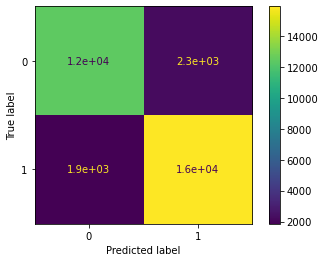

In [47]:
import matplotlib.pyplot as plt
# Construct and display the confusion matrix.

# Construct the confusion matrix for the predicted and test values.
cm = metrics.confusion_matrix(y_test,y_pred)

# Create the display for the confusion matrix.
cm_disp = metrics.ConfusionMatrixDisplay(cm,display_labels =XGB_cv.classes_)

# Plot the visual in-line.
cm_disp.plot()
plt.show()

### Confusion Matrix Interpretation

The confusion matrix provides a detailed breakdown of the model's predictions compared to the actual outcomes. The following values were obtained:

- **True Positives (TP): 16,000**
  - This represents the number of satisfied customers that the model correctly predicted as satisfied. A high TP value indicates that the model is effective in identifying customers who are genuinely satisfied.

- **False Positives (FP): 2,300**
  - This indicates the number of unsatisfied customers that the model incorrectly predicted as satisfied. While a moderate FP count suggests some misclassifications, it's essential to monitor this value as it reflects the model's tendency to overpredict satisfaction.

- **True Negatives (TN): 12,000**
  - This value signifies the number of unsatisfied customers that the model correctly predicted as unsatisfied. A high TN count demonstrates the model's capability to accurately identify customers who are not satisfied.

- **False Negatives (FN): 1,900**
  - This indicates the number of satisfied customers that the model incorrectly predicted as unsatisfied. Although this FN count is lower than the FP count, it's important to minimize it to ensure that satisfied customers are not overlooked.

### Visualizing most important features

`xgboost` has a built-in function to visualize the relative importance of the features in the model using `matplotlib`. 
Outputting and examining the feature importance of the model.

<Figure size 864x432 with 0 Axes>

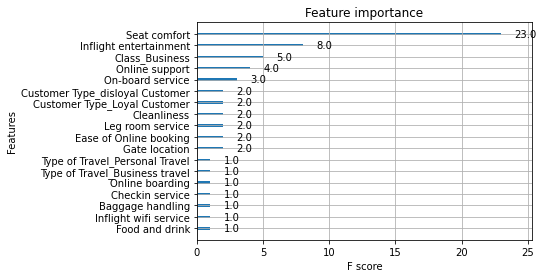

In [63]:
# Plot the relative feature importance of the predictor variables in the model.

plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plot_importance(XGB_cv.best_estimator_)
plt.show()

### Key features identified:
1. `Seat comfort`
2. `Inflight entertainment`
3. `Class_Business`
4. `Online support`

- By a wide margin, "seat comfort" rated as most important in the model.The type of seating is very different between first class and coach seating. However, the perks of being in first class also go beyond the seating type, so perhaps that is an underlying explanation of this feature's importance.

- Surprisingly, delays (both arrival and departure) did not score as highly important.

### Comparing models

Creating a table of results to compare the models performance `Tuned Decision Tree`, `Tuned Random Forest`, `Tuned XGBoost`.

In [65]:
# Create a table of results to compare model performance.

XGB_df = pd.DataFrame({
    'Model': ["Tuned Decision Tree", "Tuned Random Forest", "Tuned XGBoost"],
                      'F1': [0.945422, 0.947306, f1_score],
                      'Recall': [0.935863, 0.944501, recall],
                      'Precision': [0.955197, 0.950128, precision],
                      'Accuracy': [0.940864, 0.942450, accuracy] 
})

XGB_df



,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.945422,0.935863,0.955197,0.940864
1,Tuned Random Forest,0.947306,0.944501,0.950128,0.942450
2,Tuned XGBoost,0.885422,0.895735,0.875344,0.873114


## Conclusion

### Key Insights with Metric Interpretations

1. **Model Performance**: The `Tuned Random Forest` model achieved a remarkable `F1 score of 0.947`, indicating a high balance between precision and recall. The `recall of 0.945` means that the model correctly identifies approximately `94.5%` of satisfied customers, showcasing its effectiveness in capturing true positives. A `precision of 0.950` indicates that when the model predicts a customer is satisfied, it is correct about `95%` of the time. Finally, an `accuracy of 0.942` reflects that about `94.2%` of all predictions made by the model are correct, highlighting its overall reliability.


2. **Confusion Matrix Insights**: The confusion matrix breakdown reveals that the model identified `16,000` satisfied customers `(True Positives)`, which illustrates a strong ability to recognize the majority of satisfied customers. The `12,000 True Negatives` indicate a solid performance in correctly identifying unsatisfied customers. However, the presence of `2,300 False Positives` signifies that some unsatisfied customers were incorrectly classified as satisfied, while `1,900 False Negatives` indicates missed opportunities where satisfied customers were not recognized. The higher True Positive rate suggests that the model is quite effective in recognizing satisfied customers, yet the misclassifications point to areas needing improvement for more accurate predictions.

3. **Key Features Identified**: The analysis highlighted several key features impacting customer satisfaction: 
   - **Seat Comfort**: By a wide margin, this feature rated as the most important in the model. The differences in seating between first class and coach likely explain its significance, as first class offers more than just seating type—additional perks may contribute to overall satisfaction.
   - **Inflight Entertainment**: Another important feature, suggesting that entertainment options play a significant role in the flying experience.
   - **Class_Business**: Indicates that flying business class correlates with higher satisfaction levels.
   - **Online Support**: Highlights the importance of support services in enhancing customer experiences.

   Interestingly, **delays (both arrival and departure)** did not score as highly important, suggesting that factors beyond timeliness significantly influence customer satisfaction.

4. **Comparison with Other Models**: The `Tuned Decision Tree` performed closely to the Random Forest, with an `F1 score of 0.945`. This suggests that it also maintains a good balance between precision and recall, making it a strong contender. In contrast, the `Tuned XGBoost` demonstrated lower metrics, with an `F1 score of 0.885` and `accuracy of 0.873`. This indicates that while the model still performs decently, it is less effective at correctly identifying satisfied customers compared to the other two models. The limited hyperparameter tuning for XGBoost likely restricted its optimization, contributing to its lower performance.

### Summary for Stakeholders
- The **Tuned Random Forest** model demonstrates strong performance metrics, with high precision, recall, and accuracy rates. Given its superior performance across multiple metrics, I recommend the Tuned Random Forest model for predicting customer satisfaction. It demonstrates robust accuracy and reliability, making it suitable for operational use. 

- The **Tuned Decision Tree** also presents a strong alternative and could be considered if simpler models are desired for easier interpretability. Meanwhile, the **Tuned XGBoost** model's performance may be improved with more comprehensive hyperparameter tuning, exploring a wider range of parameters could help maximize its predictive capabilities.


- Key features influencing customer satisfaction, particularly **seat comfort**, emphasize the need to focus on enhancing passenger experience through improved seating and entertainment options. Notably, delays were not as impactful on satisfaction scores, indicating that the airline may have opportunities to enhance overall customer experience by addressing other contributing factors.

*These insights provide a roadmap for strategic decisions aimed at improving customer satisfaction and refining model performance for future predictions*
